In [14]:
from PIL import Image
import numpy as np
from transformers import OwlViTProcessor, OwlViTForObjectDetection
import torch
from PIL import ImageDraw



In [70]:
import requests
from PIL import Image
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

from transformers import Owlv2Processor, Owlv2ForObjectDetection

processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")

# Load your image
image = Image.open("../data/thor_hammer.jpeg").convert("RGB")

text_queries = ["hammer"]  # replace with what you want to detect

# Process the image with text queries
inputs = processor(text=text_queries, images=image, return_tensors="pt").to('cpu')

# Get predictions
with torch.no_grad():
    outputs = model(**inputs)

# Post-process the predictions
target_sizes = torch.Tensor([image.size[::-1]])
results = processor.post_process_object_detection(
    outputs=outputs,
    target_sizes=target_sizes,
    threshold=0.1  # Adjust this threshold as needed
)
# Extract results
boxes, scores, labels = results[0]["boxes"], results[0]["scores"], results[0]["labels"]




/Users/andrewdelacruz/e2e_sam2/venv/lib/python3.11/site-packages/transformers/models/owlv2/processing_owlv2.py:213: FutureWarning: `post_process_object_detection` method is deprecated for OwlVitProcessor and will be removed in v5. Use `post_process_grounded_object_detection` instead.
  warnings.warn(


IOU: 0.051207151263952255
IOU: 0.0
IOU: 0.0
Detected hammer with confidence 0.468 at location [71.1, 48.26, 125.31, 145.32]
Detected hammer with confidence 0.243 at location [90.7, 110.53, 132.1, 118.39]
Detected hammer with confidence 0.183 at location [0.54, 130.87, 61.83, 149.86]


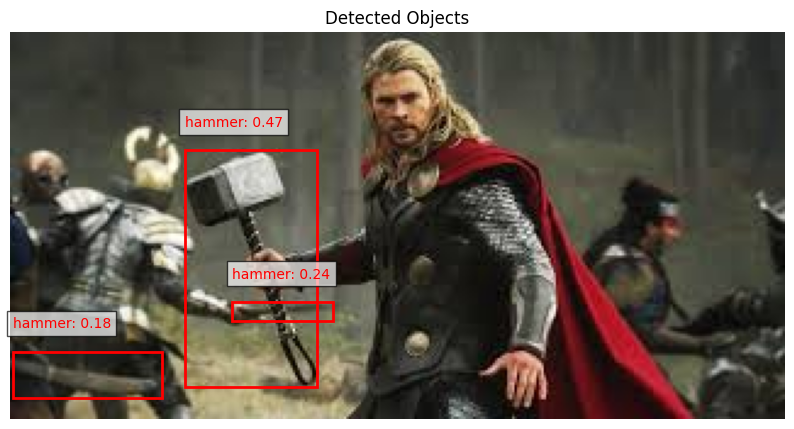

In [75]:
#  Function to calculate IoU (Intersection over Union)
def calculate_iou(box1, box2):
    # Extract coordinates
    x1_1, y1_1, x2_1, y2_1 = box1
    x1_2, y1_2, x2_2, y2_2 = box2
    
    # Calculate intersection area
    x_left = max(x1_1, x1_2)
    y_top = max(y1_1, y1_2)
    x_right = min(x2_1, x2_2)
    y_bottom = min(y2_1, y2_2)
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # Calculate box areas
    box1_area = (x2_1 - x1_1) * (y2_1 - y1_1)
    box2_area = (x2_2 - x1_2) * (y2_2 - y1_2)
    
    # Calculate IoU
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou

# Filter out overlapping boxes
filtered_indices = []
box_areas = [(box[2] - box[0]) * (box[3] - box[1]) for box in boxes]

for i in range(len(boxes)):
    keep = True
    for j in range(len(filtered_indices)):
        idx = filtered_indices[j]
        iou = calculate_iou(boxes[i], boxes[idx])
        
        # If boxes overlap significantly
        if iou > 0.5:
            # Keep the larger box
            if box_areas[i] > box_areas[idx]:
                filtered_indices[j] = i  # Replace smaller box with larger one
                keep = False
                break
            else:
                keep = False
                break
    
    if keep:
        filtered_indices.append(i)

# Create filtered lists
filtered_boxes = [boxes[i] for i in filtered_indices]
filtered_scores = [scores[i] for i in filtered_indices]
filtered_labels = [labels[i] for i in filtered_indices]

# Print results
for box, score, label in zip(filtered_boxes, filtered_scores, filtered_labels):
    box_list = [round(i, 2) for i in box.tolist()]
    print(f"Detected {text_queries[label]} with confidence {round(score.item(), 3)} at location {box_list}")

# Plot the image with bounding boxes
plt.figure(figsize=(10, 8))
plt.imshow(np.array(image))
plt.axis('off')
plt.title('Detected Objects')

# Create a figure for displaying the image with bounding boxes
ax = plt.gca()

# Define colors for different classes
colors = ['r', 'g', 'b', 'y', 'c', 'm']

# Add bounding boxes to the image
for box, score, label in zip(filtered_boxes, filtered_scores, filtered_labels):
    # Convert box tensor to list
    box = box.detach().cpu().numpy()
    
    # Create a Rectangle patch
    x, y, x2, y2 = box
    width = x2 - x
    height = y2 - y
    
    # Choose color based on label
    color = colors[label % len(colors)]
    
    # Add the rectangle to the plot
    rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    
    # Add label and confidence score
    plt.text(x, y-10, f"{text_queries[label]}: {score:.2f}", color=color, fontsize=10, 
             bbox=dict(facecolor='white', alpha=0.7))

plt.show()

In [61]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [62]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: mps

Support for MPS devices is preliminary. SAM 2 is trained with CUDA and might give numerically different outputs and sometimes degraded performance on MPS. See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion.


In [93]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True,score_threshold=0.5):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        if score < score_threshold:
            continue

        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [90]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

2025-04-14 11:06:34,105 - INFO - Loaded checkpoint sucessfully


In [94]:

def predict_with_box(image, box):
    """
    Predict segmentation mask using SAM2 with a bounding box input
    Args:
        image: RGB image as numpy array
        box: Bounding box in format [x1, y1, x2, y2]
    Returns:
        masks: Predicted segmentation masks
    """
    # Set image for prediction
    predictor.set_image(image)
    
    # Convert box to torch tensor and correct format
    box_torch = torch.tensor(box, device=predictor.device)[None, :]
    
    # Get prediction
    with torch.inference_mode():
        masks, scores, logits = predictor.predict(
            point_coords=None,
            point_labels=None, 
            boxes=box_torch,
            multimask_output=False
        )
    
    return masks[0], scores[0]

# Example usage:
# box = [x1, y1, x2, y2] # Coordinates in absolute pixels
# masks, scores = predict_with_box(image, box)

2025-04-14 11:15:04,661 - INFO - For numpy array image, we assume (HxWxC) format
2025-04-14 11:15:07,364 - INFO - Computing image embeddings for the provided image...
2025-04-14 11:15:20,705 - INFO - Image embeddings computed.


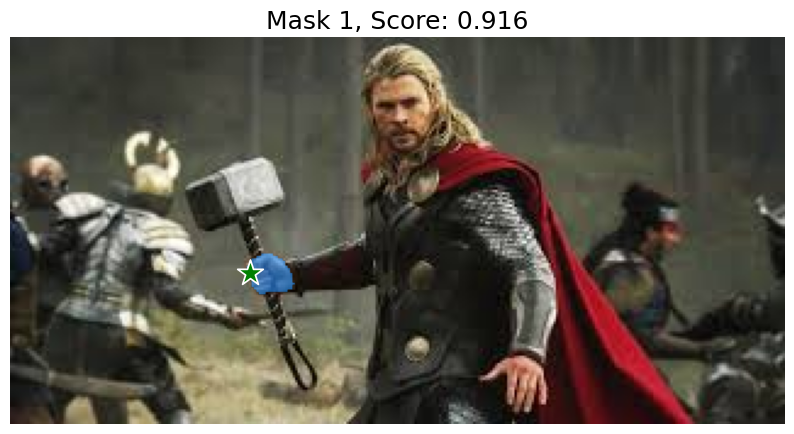

2025-04-14 11:15:22,274 - INFO - For numpy array image, we assume (HxWxC) format
2025-04-14 11:15:22,393 - INFO - Computing image embeddings for the provided image...
2025-04-14 11:15:49,379 - INFO - Image embeddings computed.


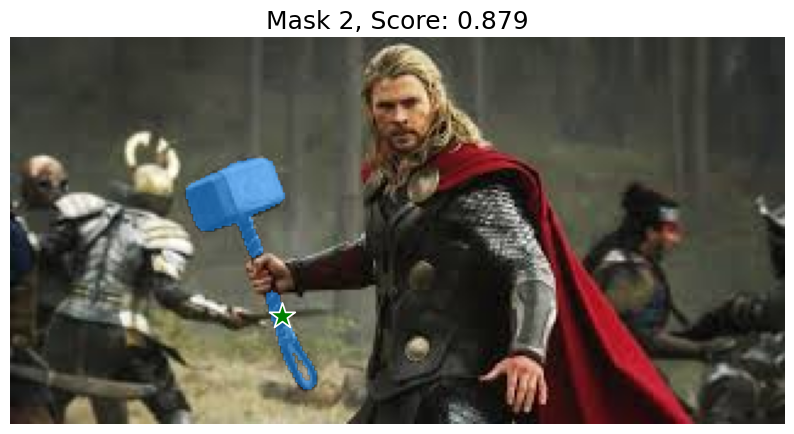

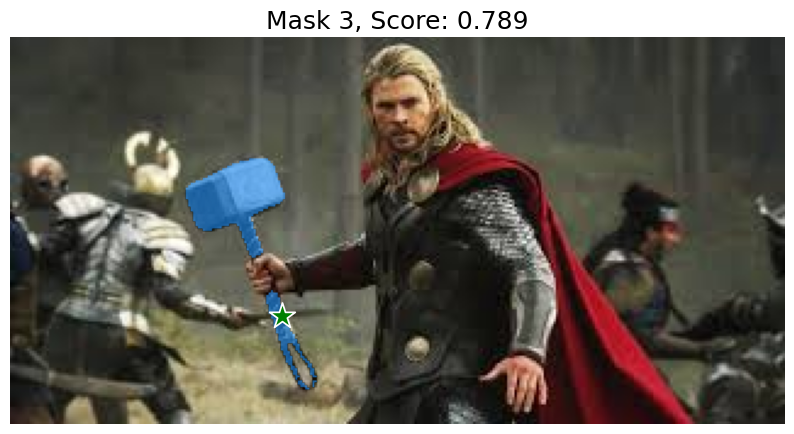

2025-04-14 11:15:51,098 - INFO - For numpy array image, we assume (HxWxC) format
2025-04-14 11:15:51,399 - INFO - Computing image embeddings for the provided image...
2025-04-14 11:16:04,312 - INFO - Image embeddings computed.


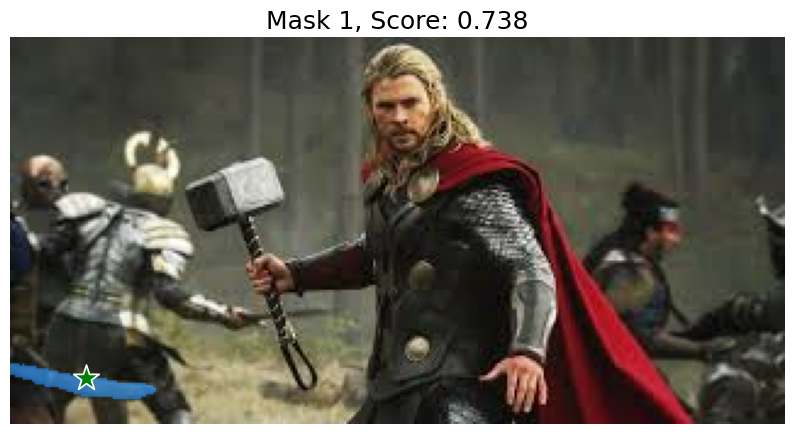

In [97]:
import os
from PIL import Image
import numpy as np

# Create results folder if it doesn't exist
results_folder = "../results"
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

seg_image = Image.open("../data/thor_hammer.jpeg").convert("RGB")
seg_image_np = np.array(seg_image)

for idx, box in enumerate(filtered_boxes):
    # Extract box coordinates
    x1, y1, x2, y2 = [int(coord) for coord in box]
    
    # Crop the image using the bounding box
    cropped_image = seg_image.crop((x1, y1, x2, y2))
    
    # Save the cropped image
    output_path = os.path.join(results_folder, f"box_{idx}.png")
    cropped_image.save(output_path)
    
    # Calculate a point in the center of the box
    x_center = (x1 + x2) / 2
    y_center = (y1 + y2) / 2
    
    # Create point coordinates
    point_coords = np.array([[x_center, y_center]])
    point_labels = np.array([1])  # 1 indicates a foreground point
    
    # Set image for prediction
    predictor.set_image(seg_image_np)
    
    # Predict with both box and point
    with torch.inference_mode():
        masks, scores, logits = predictor.predict(
            point_coords=point_coords,
            point_labels=point_labels,
            multimask_output=True
        )
    show_masks(image, masks, scores, point_coords=point_coords, input_labels=point_labels, borders=False)

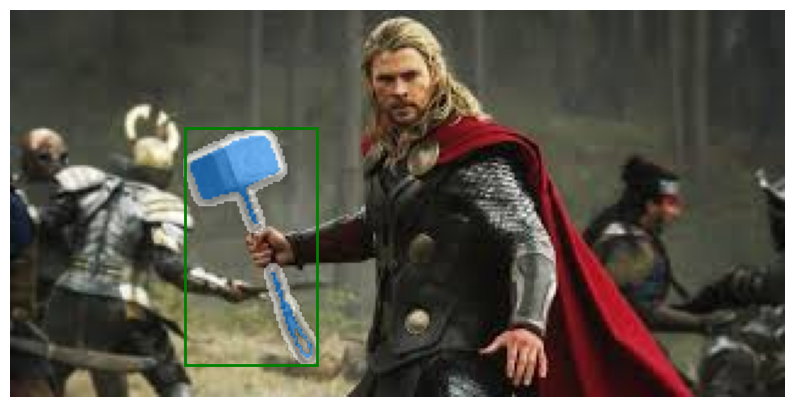

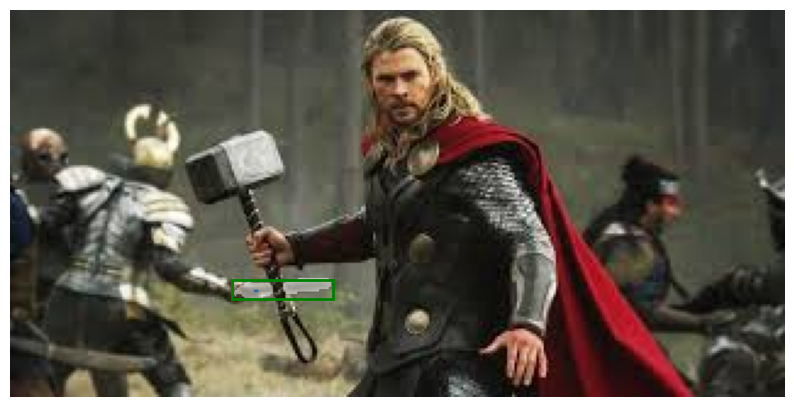

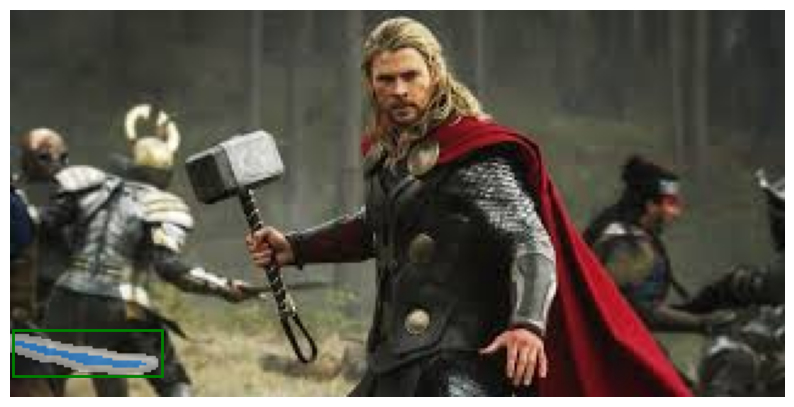

In [98]:

for idx, box in enumerate(filtered_boxes):
    # Extract box coordinates
    x1, y1, x2, y2 = [int(coord) for coord in box]
    masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=box[None, :],
    multimask_output=False,
)
    show_masks(image, masks, scores, box_coords=box),

    

In [57]:
image_path = "../data/thor_hammer.jpeg"
image_target = Image.open(image_path)
# Create a copy of the image for drawing

query_url = "../data/mjolnir_gt.jpeg"
query_image = Image.open(query_url)
inputs = processor(images=image_target, query_images=query_image, return_tensors="pt")


In [58]:
with torch.no_grad():
    outputs = model.image_guided_detection(**inputs)
    target_sizes = torch.tensor([image_target.size[::-1]])
    results = processor.post_process_image_guided_detection(outputs=outputs, target_sizes=target_sizes)[0]


scores = results["scores"].tolist()
boxes = results["boxes"].tolist()



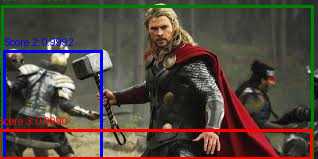

In [60]:
image_target_copy = image_target.copy()

draw = ImageDraw.Draw(image_target_copy)

# Find the top 3 scores and their corresponding boxes
top_scores_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:3]
top_scores = [scores[i] for i in top_scores_indices]
top_boxes = [boxes[i] for i in top_scores_indices]

# Draw all top 3 boxes with different colors
colors = ["green", "blue", "red"]
for i, (score, box) in enumerate(zip(top_scores, top_boxes)):
    xmin, ymin, xmax, ymax = box
    draw.rectangle((xmin, ymin, xmax, ymax), outline=colors[i], width=3)
    draw.text((xmin, ymin-15), f"Score {i+1}: {score:.4f}", fill=colors[i])

image_target_copy

In [81]:
# Define the bounding boxes
box1 = [71.1, 48.26, 125.31, 145.32]
box2 = [90.7, 110.53, 132.1, 118.39]
box3 = [0.54, 130.87, 61.83, 149.86]

# Function to calculate IoU (Intersection over Union)
def calculate_iou(box_a, box_b):
    # Extract coordinates and convert to integers
    x_a1, y_a1, x_a2, y_a2 = map(int, box_a)
    x_b1, y_b1, x_b2, y_b2 = map(int, box_b)
    
    # Calculate intersection area
    x_left = max(x_a1, x_b1)
    y_top = max(y_a1, y_b1)
    x_right = min(x_a2, x_b2)
    y_bottom = min(y_a2, y_b2)
    
    # No intersection if boxes don't overlap
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # Calculate areas of both boxes
    box_a_area = (x_a2 - x_a1) * (y_a2 - y_a1)
    box_b_area = (x_b2 - x_b1) * (y_b2 - y_b1)
    
    # Calculate IoU
    iou = intersection_area / float(box_a_area + box_b_area - intersection_area)
    return iou

# Calculate IoU between all pairs of boxes
iou_1_2 = calculate_iou(box2, box1)
iou_1_3 = calculate_iou(box1, box2)
iou_2_3 = calculate_iou(box3, box1)

print(f"IoU between box 1 and box 2: {iou_1_2:.4f}")
print(f"IoU between box 1 and box 3: {iou_1_3:.4f}")
print(f"IoU between box 2 and box 3: {iou_2_3:.4f}")

IoU between box 1 and box 2: 0.0529
IoU between box 1 and box 3: 0.0529
IoU between box 2 and box 3: 0.0000
